In [28]:
%pylab inline
import scipy.stats as stats
from scipy.stats import binom
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML, Image

rc('animation', html='html5')

Populating the interactive namespace from numpy and matplotlib


/home/vagrant/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


So far we've covered some important ground. We know we can frame election outcomes as binomial processes, and we can capture invalid votes. With this knowledge, we're ready to start asking questions about election outcomes. 

Let's imagine an election with 1,000 ballots in it, where Alice gets 600 votes, Bob gets 300 votes, and 100 votes are invalid. In probability space, this election is pretty boring: 

(-900.0, 900.0)

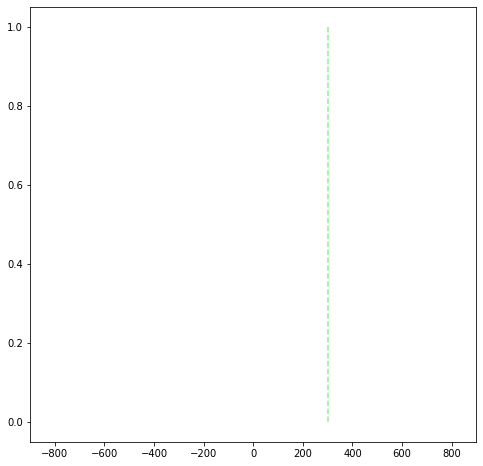

In [29]:
n = 1000
v_w = 600
v_l = 300

fig, ax = plt.subplots(figsize=(8,8))
ax.vlines(600-300, color='lightgreen', linestyle='dashed', ymin=0, ymax=1)
ax.set_xlim(-(v_w + v_l), v_w + v_l)

Now let's say that we are told those election results, but we don't necessarily believe them outright. Elections are inherently messy processes, so it's possible the counts are off a little bit. Worse, it's possible someone has deliberately tampered with the outcome to make Alice win instead of Bob. Let's plot the election result as a distribution instead.

Variance: 210.00


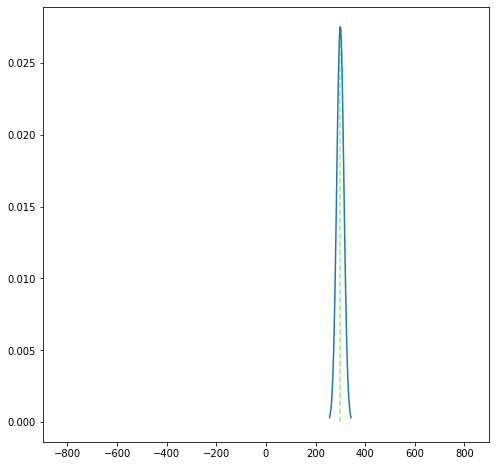

In [30]:
ax.cla()
n = 1000

mu = v_w - v_l
variance = mu*(1 - mu/n)
print('Variance: {:2.2f}'.format(variance))
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.vlines(mu, color='lightgreen', linestyle='dashed', ymin=0, ymax=stats.norm.pdf(mu, mu, sigma))
ax.set_xlim(-(v_w + v_l), v_w + v_l)

fig

If we want to use this distribution to ask "how likely is is that Bob actually won?", we can take the area under the curve from $-\infty$ to 0. 

In [31]:
p_bob_won = stats.norm.pdf(0, mu, sigma)
print(f"Bob won with probabilitiy {p_bob_won}")

Bob won with probabilitiy 2.380658785845715e-95


That's a really small number! It seems like our model isn't doing a great job of accounting for the fact that the election outcome could be wrong. Ideally, we'd like to come up with a better model that better accounts for that. One way to to it is to conduct a hypothesis test. We frame a hypothesis: "Alice didn't win", and then collect some data to try to reject that hypothesis. Our alternative hypothesis might be that "Alice really won".

Visually, our hypothesis test might look something like this (for simplicity, I'm omitting the parts of the probability space we don't care about):

Variance: 210.00


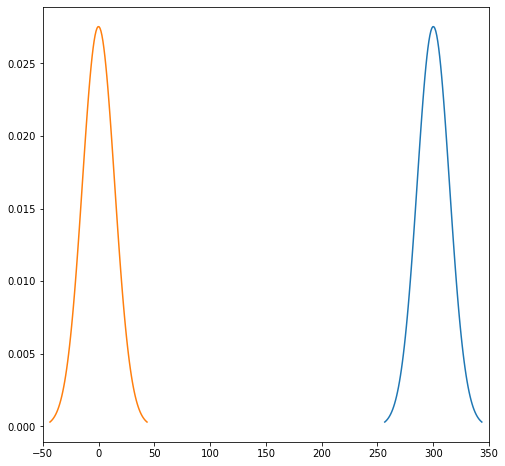

In [32]:
ax.cla()
n = 1000

mu = v_w - v_l
variance = mu*(1 - mu/n)
print('Variance: {:2.2f}'.format(variance))
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))

mu = 0
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, 0, sigma))

ax.set_xlim(-50, 350)

fig

The orange distribution is our null hypothesis. Now, let's collect some data. Let's say we draw 120 ballots, and find that 72 are for Alice, 36 are for Bob, and 12 are invalid. This means that we have a sample with a margin of 36 ballots. Plotting our sample:

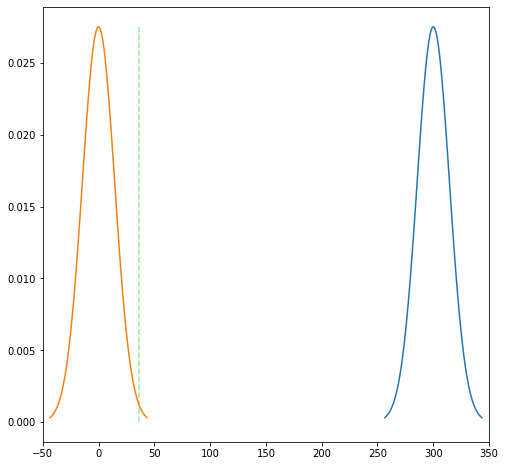

In [33]:
ax.vlines(36, color='lightgreen', linestyle='dashed', ymin=0, ymax=stats.norm.pdf(mu, mu, sigma))
fig

Hmm, it sort of looks like our sample might be more likely to come from the null distribution, even though it shows a clear preference for Alice. What's going on?

One issue here is scaling. So far, we've been showing margins as absolute numbers of votes. Let's try making it proportion of votes, and plotting our sample again. 

Variance: 0.00


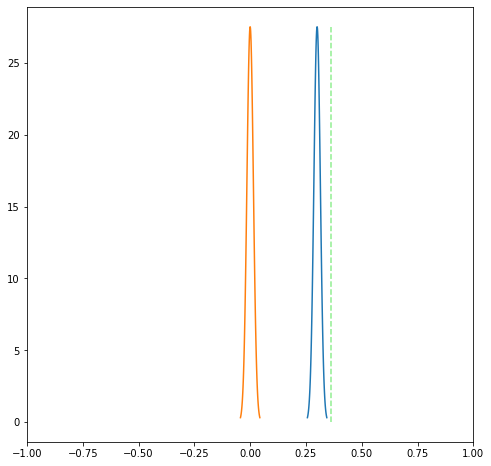

In [34]:
ax.cla()
N = 1000

mu = (v_w - v_l)/N
variance = (mu/N)*(1 - mu)
print('Variance: {:2.2f}'.format(variance))
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))

mu = 0
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, 0, sigma))

ax.set_xlim(-1, 1)

ax.vlines(.36, color='lightgreen', linestyle='dashed', ymin=0, ymax=stats.norm.pdf(mu, mu, sigma))
fig

Whoa! Now it looks much more likely that our sample doesn't come from the null distribution. (TODO: what's up with proportion vs. absolute?). Is there a way we can quantify how likely it is that our sample would come from either distribution?

As it just so happens, a Sequential Probability Ratio Test (SPRT) might be just the ticket! The SPRT is a **likelihood-ratio test**, which uses the ratio of two likelihoods to made a determination about the hypotheses. A likelihood is just the value of a given distribution at a particular point. A likelihood ratio test examines the likelihood of the data under the null hypothesis divided by the likelihood under the alternative. So we just need to evaluate our null and alternative and take their ratio accordingly.

In [39]:
null_dist= stats.norm(0, sigma)
mu = (v_w - v_l)/N
alt_dist = stats.norm(mu, sigma)

null_likelihood = null_dist.pdf(.36)
alt_likelihood = alt_dist.pdf(.36)

# print(null_likelihood, alt_likelihood)
print(null_likelihood/alt_likelihood)

5.14820022241239e-131


That's a really small number! But what does it mean? That number is a p-value, however, we need some more context to evaluate it. 

The sequential probability ratio test requires us to set "stopping" rules parameterized by two numbers $a$ and $b$, which in turn depend on two other numbers, $\alpha$ and $\beta$. $\alpha$ corresponds to the probability of a false positive, while $\beta$ corresponds to the probability of a false negative. 

In our example, our test should reject the null hypothesis when we have sufficient evidence that the election result really did go for the winner. If we reject the null hypothesis when this is not the case, it means that we are "accepting" an election outcome that may be incorrect.

In principle, we always want to reject the null hypothesis when it is false. If we do not do that, then it's possible that we could overturn a correct election result. This means that if we're ever in a scenario where a false negative is possible, we should be counting all of our ballots. So for our purposes we are going to set $\beta$ to 0. $\alpha$ controls how certain we would like to be before stopping the audit. A good value is $\alpha = 0.05$, meaning that we are confidence that our election result is correct at least 95\% of the time before we stop our audit.

Since we're using a $\beta$ of 0, we can ignore one of the stopping rules. We thus have our rule:

$$b = \log \frac{1}{\alpha}$$

Hang on, where'd that log come from? It turns out that the likelihood ratio we're looking for, per the SPRT, is a log-likelihood. Taking the log of each of our likelihoods and then taking their ratio:

In [53]:
null_LR = null_dist.logpdf(.36)
alt_LR = alt_dist.logpdf(.36)

print(null_LR/alt_LR)

58.075827388908884


That's a much bigger number. How does it compare with our stopping condition?

In [42]:
stopping_condition = np.log(1/.05)
print(stopping_condition)

2.995732273553991


Hmm, so we've foud that our ratio is _greater than_ our stopping condition. Per the SPRT, that means we need to sample more ballots!

Let's say we sample 20 more ballots, and all of them are votes for Alice. So now the margin proportion of our sample is $\frac{92}{140} = .6571\dots$, and our likelihood ratio is:

null_LR = null_dist.logpdf(.657)
alt_LR = alt_dist.logpdf(.657)


print(null_LR/alt_LR)

Aww shoot! It was so close! Let's sample 20 more Alice ballots.

In [57]:
null_LR = null_dist.logpdf(.7)
alt_LR = alt_dist.logpdf(.7)

print(1/np.exp(null_LR/alt_LR))
print(null_LR/alt_LR)

0.04593138552988474
3.0806066149795726


Wow, even with a sample containing 112 votes for Alice, 36 for Bob, and 12 invalid votes, we _still_ haven't met the stopping condition! Let's try 130 Alice ballots.

In [52]:
sample_ratio = (130/168)

null_LR = null_dist.logpdf(sample_ratio)
alt_LR = alt_dist.logpdf(sample_ratio)


print(null_LR/alt_LR)

2.6776359933345604


There we go! Now our likelihood ratio is below the stopping condition! We can stop! But it sure did take a skewed sample to get here, huh?

Fun fact, if we take our likelihood ratio, exponentiate it, and then divide one by it, we get a p-value. TODO: why does the p-value fall below $\alpha$ before the LR falls below **b**?